In [114]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Conexão com banco de dados
import sqlite3

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

# Modelo preditivo (XGBoost recomendado)
from xgboost import XGBRegressor

# Avaliação de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Divisão dos dados
from sklearn.model_selection import train_test_split, cross_val_score

# Outliers
from sklearn.ensemble import IsolationForest

# Visualização dos resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações gerais de visualização
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Para trabalhar caminhos de arquivos robustamente
from pathlib import Path

# Ignore warnings desnecessários
import warnings
warnings.filterwarnings('ignore')

# Para controle de randomização (reprodutibilidade)
import random

# Visualização de progresso
from tqdm import tqdm

In [30]:
np.random.seed(42)
random.seed(42)


DATA_PATH = Path('../data/df_for_training.csv')

In [31]:
df = pd.read_csv(DATA_PATH)

#Criando identificador único
df['Index'] =  df['StockCode'] + '_' + df['InvoiceYearMonth'].apply(lambda x: x.replace('-', ''))

#Extração do mês
df['Month'] = df['InvoiceYearMonth'].apply(lambda x: x.split('-')[1]).astype(int)
df.set_index('Index', inplace=True)

#Dropamos a coluna pois não precisamos do ano, apenas da referência do mês, dado que optamos por não trabalhar diretamente com séries temporais
df.drop(columns=['InvoiceYearMonth', 'log_total_quantity'], inplace= True)

# Remoção de outliers numéricos

In [32]:
cat_cols = ['Country']
time_cols = ['Month']
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in time_cols]
passthrough_cols = ['price_change_direction',
                    'is_end_of_quarter',
                    'is_holiday_season']

In [33]:
# Criar Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Ajustar o modelo
df['Anomaly'] = iso_forest.fit_predict(df[numeric_cols])

# Remover os outliers identificados (anomaly = -1)
df_clean = df[df['Anomaly'] == 1]

df_clean.drop(columns= 'Anomaly', inplace = True)

# Engenharia de Features

In [34]:
# Dando relevancia maior para aumento de demanda quando preço reduz
df_clean['price_change_direction'] = np.sign(df_clean['price_change'])*(-1)

In [40]:
df_clean = df_clean[df_clean['price_change_direction'] != 0]

In [41]:
df_clean = df_clean.sort_values(by=['Index'])

#Média dos ultimos 3 meses
df_clean['rolling_avg_price'] = df_clean.groupby('StockCode')['avg_price_monthly'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_clean['rolling_demand_volatility'] = df_clean.groupby('StockCode')['total_quantity'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))

numeric_cols = list(set(numeric_cols + ['rolling_avg_price', 'rolling_demand_volatility']))

print(numeric_cols)

['total_quantity', 'avg_price_monthly', 'rolling_demand_volatility', 'rolling_avg_price', 'price_change']


In [43]:
df_clean['is_start_of_year'] = (df_clean['Month'] == 1).astype(int)
df_clean['is_end_of_quarter'] = df_clean['Month'].isin([3, 6, 9, 12]).astype(int)
df_clean['is_holiday_season'] = df_clean['Month'].isin([11, 12]).astype(int)

In [44]:
[*numeric_cols, *cat_cols, *passthrough_cols, *time_cols]

['total_quantity',
 'avg_price_monthly',
 'rolling_demand_volatility',
 'rolling_avg_price',
 'price_change',
 'Country',
 'price_change_direction',
 'is_end_of_quarter',
 'is_holiday_season',
 'Month']

In [45]:
df_final = df_clean[[*numeric_cols, *cat_cols, *passthrough_cols, *time_cols]]

In [46]:
# total_quantity é o target (y), não deve estar nas features
X = df_final.drop(columns=["total_quantity"])
y = df_final["total_quantity"]

# garanta que total_quantity não está nas listas
numeric_cols = [col for col in numeric_cols if col != "total_quantity"]
passthrough_cols = [col for col in passthrough_cols if col != "total_quantity"]

# Pipeline de processamento

Como usaremos modelos de ávore, não usaremos nenhum scaler de início

In [47]:
print(f'pass: {passthrough_cols}')
print(f'categorical: {cat_cols}')
print(f'numeric: {numeric_cols}')
print(f'tempo: {time_cols}')

pass: ['price_change_direction', 'is_end_of_quarter', 'is_holiday_season']
categorical: ['Country']
numeric: ['avg_price_monthly', 'rolling_demand_volatility', 'rolling_avg_price', 'price_change']
tempo: ['Month']


In [48]:
class CyclicalFeaturesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cyclical_cols = 'Month'):
        """
        cyclical_cols: dict, ex: {"Month": 12}
        """
        self.cyclical_cols = cyclical_cols
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        for col, max_val in self.cyclical_cols.items():
            X_[f"{col}_sin"] = np.sin(2 * np.pi * X_[col] / max_val)
            X_[f"{col}_cos"] = np.cos(2 * np.pi * X_[col] / max_val)
            X_.drop(columns=[col], inplace=True)
        return X_

In [49]:
# Pipeline para colunas temporais com codificação cíclica
temporal_pipeline = Pipeline([
    ("cyclical", CyclicalFeaturesEncoder(cyclical_cols={col: 12 for col in time_cols}))
])

# ColumnTransformer com colunas nomeadas corretamente
column_transformer = ColumnTransformer(
    transformers=[
        ("passthrough", "passthrough", numeric_cols + passthrough_cols),
        ("temporal", temporal_pipeline, time_cols),
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop"
)

# Pipeline final com modelo
model_pipeline = Pipeline([
    ("preprocessor", column_transformer),
    ("regressor", XGBRegressor(
                                n_estimators=500,
                                learning_rate=0.05,
                                max_depth=4,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                random_state=42
                            )                       
)
])

In [50]:
X_train, X_temp , y_train, y_temp = train_test_split(X, y,
                                                    test_size= 0.4,
                                                    stratify= (X['Country'] == 'United Kingdom').values
                                                    )

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp,
                                                    test_size= 0.5
                                                    )

In [51]:
X.columns

Index(['avg_price_monthly', 'rolling_demand_volatility', 'rolling_avg_price',
       'price_change', 'Country', 'price_change_direction',
       'is_end_of_quarter', 'is_holiday_season', 'Month'],
      dtype='object')

# Inicio ML

In [52]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['avg_price_monthly',
                                                   'rolling_demand_volatility',
                                                   'rolling_avg_price',
                                                   'price_change',
                                                   'price_change_direction',
                                                   'is_end_of_quarter',
                                                   'is_holiday_season']),
                                                 ('temporal',
                                                  Pipeline(steps=[('cyclical',
                                                                   CyclicalFeaturesEncoder(cyclical_cols={'Month': 12}))]),
                                                  ['Month']),...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [53]:
y_val_pred = model_pipeline.predict(X_val)

In [54]:
print("Val MAE:", mean_absolute_error(y_val, y_val_pred))
print("Val RMSE:", mean_squared_error(y_val, y_val_pred, squared=False))  # Corrigido aqui
print("Val R²:", r2_score(y_val, y_val_pred))

Val MAE: 55.84147752164385
Val RMSE: 99.8128305911803
Val R²: 0.6533102576424894


In [55]:
y_test_pred = model_pipeline.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
print("Test R²:", r2_score(y_test, y_test_pred))

Test MAE: 57.61843591574702
Test RMSE: 103.05790776692307
Test R²: 0.623956846345759


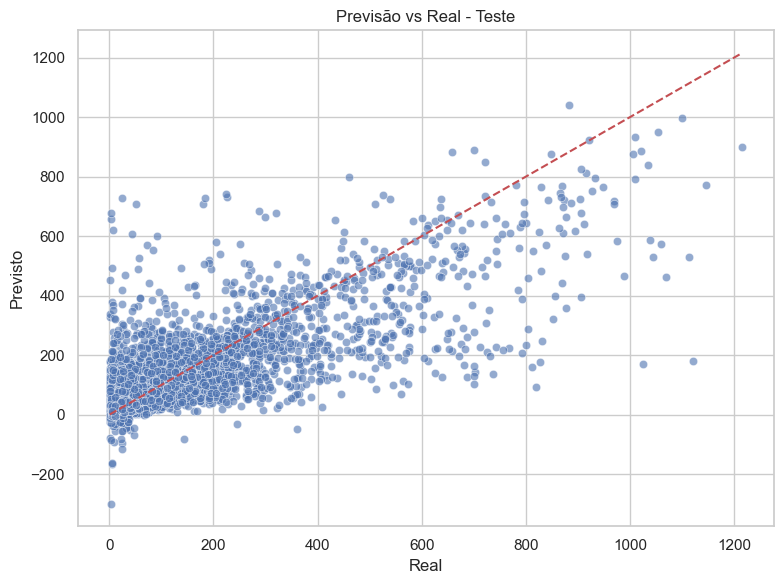

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.title("Previsão vs Real - Teste")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
model_pipeline["regressor"].feature_importances_

array([0.02603258, 0.131277  , 0.02039978, 0.03936527, 0.02159447,
       0.0188302 , 0.01496974, 0.02702727, 0.06266377, 0.00887697,
       0.        , 0.00215895, 0.        , 0.00195034, 0.        ,
       0.        , 0.064386  , 0.        , 0.08101924, 0.1511333 ,
       0.        , 0.        , 0.        , 0.        , 0.01995415,
       0.001018  , 0.02285824, 0.0028929 , 0.00185538, 0.01315833,
       0.        , 0.0040546 , 0.01183045, 0.        , 0.25069317,
       0.        ], dtype=float32)

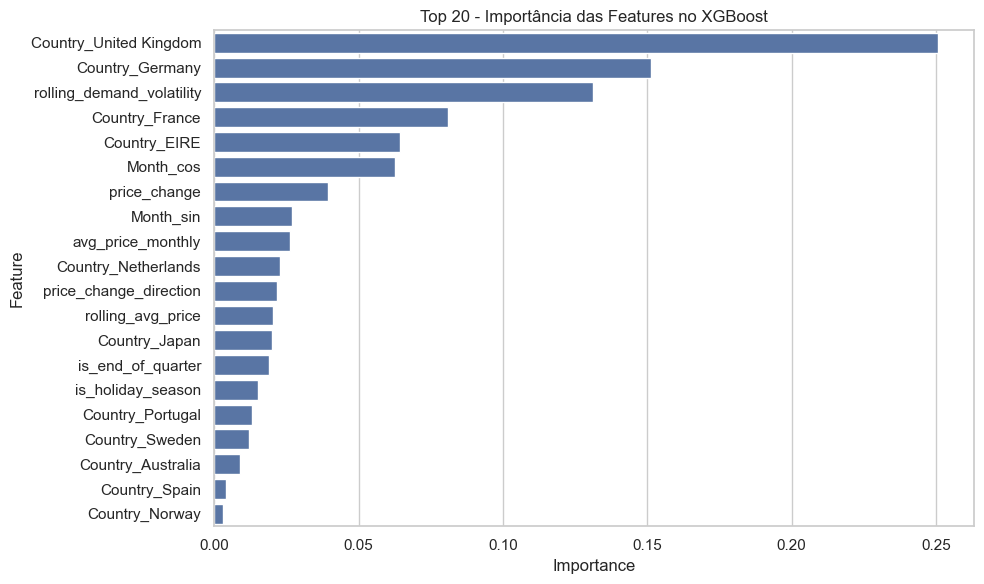

In [61]:
# Inicialmente: numéricas e passthrough
feature_names = numeric_cols + passthrough_cols

# Temporais cíclicos
for col in time_cols:
    feature_names.extend([f"{col}_sin", f"{col}_cos"])

# Categóricas (após OneHotEncoder)
ohe = model_pipeline["preprocessor"].named_transformers_["categorical"]
if hasattr(ohe, "get_feature_names_out"):
    feature_names.extend(list(ohe.get_feature_names_out(cat_cols)))
else:
    feature_names.extend(ohe.get_feature_names(cat_cols))



importances = model_pipeline["regressor"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20))
plt.title("Top 20 - Importância das Features no XGBoost")
plt.tight_layout()
plt.show()

In [65]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "regressor__n_estimators": [100, 120 ,200],  # reduzido de 4 para 2 opções
    "regressor__max_depth": [3 ,5, 7],        # reduzido de 4 para 2
    "regressor__min_samples_split": [2, 5], # mantido pequeno
    "regressor__min_samples_leaf": [1, 2, 4],  # mantido pequeno
    "regressor__max_features": ["sqrt", "log2"]     # uma única opção (mais rápida)
}

search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1
)


# Fit nos dados de treino
search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('passthrough',
                                                                               'passthrough',
                                                                               ['avg_price_monthly',
                                                                                'rolling_demand_volatility',
                                                                                'rolling_avg_price',
                                                                                'price_change',
                                                                                'price_change_direction',
                                                                                'is_end_of_quarter',
                                                                                'is_holiday_season']),
                                                                              ('temporal',
                                                                               Pipeline(steps=[('cyclical',
                                                                                                CyclicalFeaturesEncoder(cyclical...
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'regressor__max_depth': [3, 5, 7],
                                        'regressor__max_features': ['sqrt',
                                                                    'log2'],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5],
                                        'regressor__n_estimators': [100, 120,
                                                                    200]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [67]:
melhor_mae = -search.best_score_
melhores_parametros = search.best_params_

print(f"Melhor MAE na validação cruzada: {melhor_mae:.4f}")
print("Melhores hiperparâmetros encontrados:")
for parametro, valor in melhores_parametros.items():
    print(f"  {parametro}: {valor}")

Melhor MAE na validação cruzada: 56.3626
Melhores hiperparâmetros encontrados:
  regressor__n_estimators: 200
  regressor__min_samples_split: 5
  regressor__min_samples_leaf: 1
  regressor__max_features: sqrt
  regressor__max_depth: 7


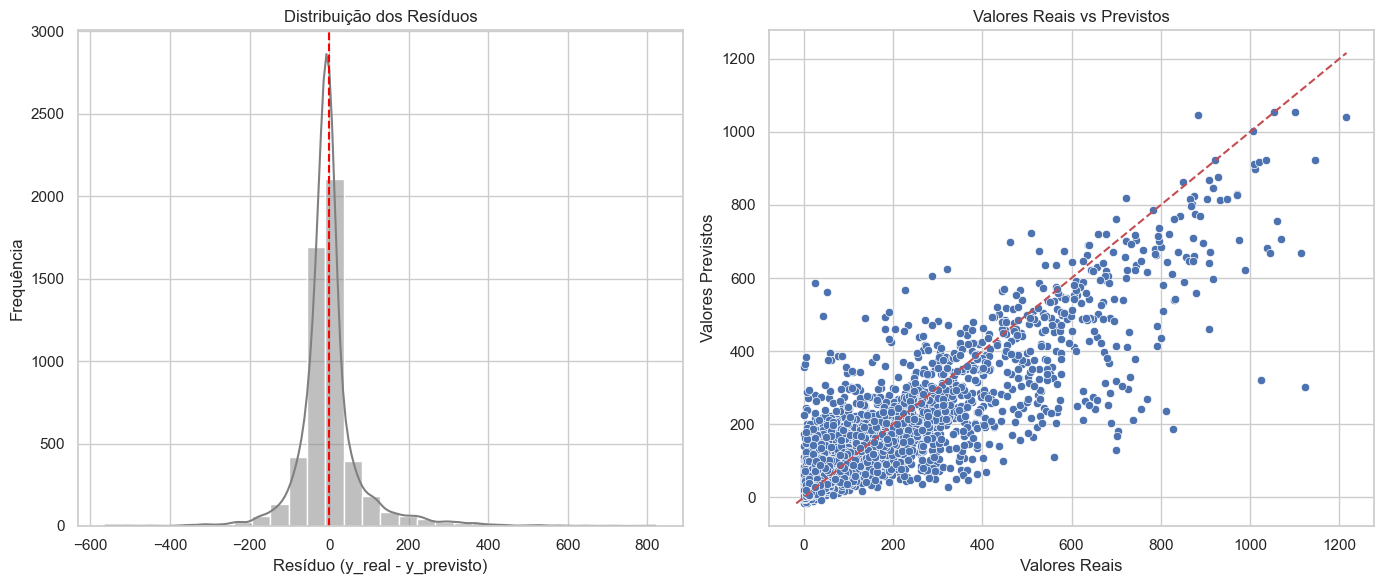

In [70]:
# Previsões com o melhor modelo
y_pred = search.predict(X_test)

# Cálculo dos resíduos
residuos = y_test - y_pred

# Figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Histograma dos Resíduos ---
sns.histplot(residuos, bins=30, kde=True, color="gray", ax=axes[0])
axes[0].axvline(0, color="red", linestyle="--")
axes[0].set_title("Distribuição dos Resíduos")
axes[0].set_xlabel("Resíduo (y_real - y_previsto)")
axes[0].set_ylabel("Frequência")

# --- Diagrama Real x Previsto ---
sns.scatterplot(x=y_test, y=y_pred, ax=axes[1])
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
axes[1].plot([min_val, max_val], [min_val, max_val], "r--")  # Linha 45°
axes[1].set_title("Valores Reais vs Previstos")
axes[1].set_xlabel("Valores Reais")
axes[1].set_ylabel("Valores Previstos")

plt.tight_layout()
plt.show()

# Aplicando Mapeamento Dinâmico

In [ ]:
model_pipeline.fit(X,y)

Index(['avg_price_monthly', 'rolling_demand_volatility', 'rolling_avg_price',
       'price_change', 'Country', 'price_change_direction',
       'is_end_of_quarter', 'is_holiday_season', 'Month'],
      dtype='object')

In [101]:
df_final["DateRef"] = df_clean.index.tolist()
df_final["SKU"] = df_final["DateRef"].apply(lambda x: x[:-7])
df_final["DateRef"] = df_final["DateRef"].apply(lambda x: x[-8:])

In [102]:
# 1. Ordena para garantir que o último mês seja o último da sequência
df_final = df_final.sort_values(by=["SKU", "DateRef"])

# 2. Separa o último mês de cada SKU
df_ultimo_mes = df_final.groupby("SKU").tail(1).copy()

# 3. Remove o último mês de cada SKU
df_sem_ultimo_mes = df_final.groupby("SKU").apply(lambda g: g.iloc[:-1]).reset_index(drop=True)

# 4. Remove colunas auxiliares
df_ultimo_mes = df_ultimo_mes.drop(columns=["DateRef", "SKU"])
df_sem_ultimo_mes = df_sem_ultimo_mes.drop(columns=["DateRef", "SKU"])

In [103]:
X_train = df_sem_ultimo_mes.drop(columns=["total_quantity"])
y_train = df_sem_ultimo_mes["total_quantity"]

In [104]:
melhor_modelo = search.best_estimator_
melhor_modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['avg_price_monthly',
                                                   'rolling_demand_volatility',
                                                   'rolling_avg_price',
                                                   'price_change',
                                                   'price_change_direction',
                                                   'is_end_of_quarter',
                                                   'is_holiday_season']),
                                                 ('temporal',
                                                  Pipeline(steps=[('cyclical',
                                                                   CyclicalFeaturesEncoder(cyclical_cols={'Month': 12}))]),
                                                  ['Month']),...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_features='sqrt', max_leaves=None,
                              min_child_weight=None, min_samples_leaf=1,
                              min_samples_split=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, ...))])

In [ ]:
df_sem_ultimo_mes["price_change"]

-0.0283419287216589

In [147]:
def plot_curva_receita(df_base, model_pipeline, seed=46, col_preco="avg_price_monthly"):
    # Fixar seed
    random.seed(seed)
    np.random.seed(seed)

    # Selecionar uma linha aleatória da base
    linha = df_base.sample(n=1, random_state=seed)

    # Função para simular preços com variação de ±25%
    def simular_precos_com_variacao_25pct(df, col_preco=col_preco, passo=0.01):
        precos_simulados = []
        for _, row in df.iterrows():
            preco_base = round(row[col_preco], 2)
            preco_min = round(preco_base * 0.75, 2)
            preco_max = round(preco_base * 1.25, 2)
            precos = np.arange(preco_min, preco_max + passo, passo)
            for p in precos:
                nova_linha = row.copy()
                nova_linha[col_preco] = round(p, 2)
                nova_linha["price_change"] = round(p - preco_base, 4)
                precos_simulados.append(nova_linha)
        return pd.DataFrame(precos_simulados)

    # Gerar simulações e prever
    df_simulados = simular_precos_com_variacao_25pct(linha, col_preco=col_preco)
    df_simulados["predicted_demand"] = model_pipeline.predict(df_simulados)
    df_simulados["predicted_demand"] = df_simulados["predicted_demand"].clip(lower=0)
    df_simulados["revenue"] = df_simulados[col_preco] * df_simulados["predicted_demand"]

    # Garantir índice limpo
    df_simulados = df_simulados.reset_index(drop=True)

    # Ponto ótimo (receita máxima)
    linha_max = df_simulados.loc[df_simulados["revenue"].idxmax()]
    preco_otimo = linha_max[col_preco]
    receita_max = linha_max["revenue"]

    # Plot da curva de receita
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_simulados, x=col_preco, y="revenue")
    plt.axvline(preco_otimo, color="red", linestyle="--", label=f"Preço ótimo: R${preco_otimo:.2f}")
    plt.title("Receita Estimada vs Preço")
    plt.xlabel("Preço Simulado")
    plt.ylabel("Receita Estimada")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_simulados, preco_otimo, receita_max


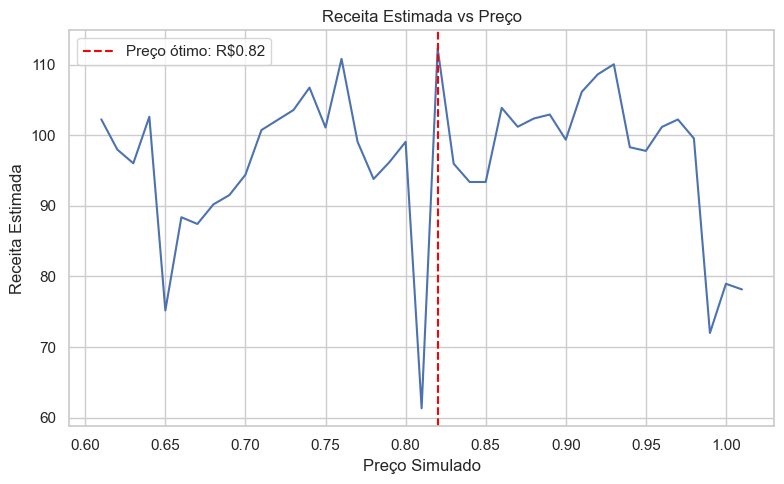

In [148]:
df_sim, preco_otimo, receita_max = plot_curva_receita(df_ultimo_mes, model_pipeline)
